In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score, precision_score, log_loss, accuracy_score, roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import seaborn as sns

import statsmodels.api as sm
from scipy.stats import norm, t
from sklearn.metrics import recall_score, precision_score, accuracy_score, roc_auc_score
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
keras = tf.keras

from src.helpers import *

In [2]:
# df produced from EDA.ipynb

df = pd.read_csv('data/model_df.csv')
df.head()

,Unnamed: 0,name,category,main_category,currency,state,backers,country,usd_pledged_real,usd_goal_real,comments_count,updates_count,spotlight,staff_pick,blurb,reward_count,launch_year,launch_month,launch_day,active_days
0,0,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,0,0,GB,0.0,1533.95,0,0,0,0,A series of poems about pure love pursued by ...,1,2015,8,11,58
1,1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,0,15,US,2421.0,30000.00,0,11,0,1,Back artists creating short movies of Greeting...,11,2017,9,2,59
2,2,Where is Hank?,Narrative Film,Film & Video,USD,0,3,US,220.0,45000.00,0,0,0,0,"Abandoned Property. Sounds of struggle, muffle...",16,2013,1,12,44
3,3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,0,1,US,1.0,5000.00,0,8,0,0,Keeping Great Reggae Music Alive Through RAW T...,6,2012,3,17,29
4,4,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,0,14,US,1283.0,19500.00,1,1,0,1,Community Film Project is creating a group tha...,8,2015,7,4,55


## Split Train/Test Set

In [3]:
# df without or 'backers' or 'usd_pledged_real' causing data leakage
# spotlight is only for successful projects so this also causes data leakage
# staff_pick varies to occur on day 1 or later on after project launch, causing data leakage

df_copy = df.drop(['Unnamed: 0','name','backers', 'usd_pledged_real', 'spotlight', 'staff_pick'], axis=1)

#dropping year month day due to non-cyclic nature, later use sklearn DictVectorizer
df_copy = df_copy.drop(['launch_year','launch_month', 'launch_day'], axis =1)

In [4]:
# Use usd_pledged_real / backers as regression target

# df_copy2 = df.drop(['state', backers])
# df_copy3 = df.drop(['state', usd_pledged_real])

In [5]:
df_copy.columns

Index(['category', 'main_category', 'currency', 'state', 'country',
       'usd_goal_real', 'comments_count', 'updates_count', 'blurb',
       'reward_count', 'active_days'],
      dtype='object')

In [6]:
# get dummies for category, main_category, currency, and country

df_copy = pd.get_dummies(df_copy, columns= ['category','main_category', 'currency', 'country'], drop_first = True)

In [7]:
# all numerical data types
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354371 entries, 0 to 354370
Columns: 214 entries, state to country_US
dtypes: float64(1), int64(5), object(1), uint8(207)
memory usage: 88.9+ MB


In [8]:
#split data into target and features
y = df_copy['state']
X = df_copy.loc[:, df_copy.columns != 'state']

In [9]:
#give % of each
# class imbalance (baseline model accuracy of 62.6% for highest class imbalance)
y.value_counts() / y.shape

0    0.62546
1    0.37454
Name: state, dtype: float64

In [10]:
# Test train split to create holdout set (X_test, y_test) with 20% of data
# stratify maintains the class balance

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)


# Numerical Feature Modeling

### Grid Search / Random Forest Model

In [11]:
# remove columns with words

X_num_train = X_train.loc[:, X_train.columns != 'blurb']
X_num_test = X_test.loc[:, X_test.columns != 'blurb']

In [12]:
parameters = {'criterion':('gini', 'entropy'), 'max_depth':[1,2,None], 'max_features': [1, 'sqrt', 'log2', None]} #max_depth 3 different times
rfc = RandomForestClassifier(n_estimators=50) #number of trees (default 100)
#gridsearch Cross Validate
gs = GridSearchCV(rfc, parameters, scoring = ['accuracy','f1', 'roc_auc'], refit='accuracy', n_jobs = -1) 
# other scoring strings
# https://scikit-learn.org/stable/modules/model_evaluation.html #model-evaluation
# refit makes it the primary ranking score out of the list we gave
# n_jobs = -1 runs the process using all cores on your computer

gs.fit(X_num_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=50, n_jobs=None,
                                              oob_score=False,
                                              ran

In [13]:
#5 K-folds done by default

pd.DataFrame(gs.cv_results_).T

# Shows Entropy is better than gini looking at mean_test_accuracy

# 3 Done for Gini and Entropy for each depth (1,2, None)

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
mean_fit_time,7.19703,10.2494,9.08435,52.718,7.29509,13.1035,9.85076,109.342,137.007,176.017,...,9.87345,59.3476,9.2929,15.2078,11.6678,119.06,147.188,192.07,172.276,617.056
std_fit_time,0.0276025,0.245157,0.0386869,0.139001,0.0663565,0.219254,0.0849158,0.742663,0.71942,2.66765,...,0.239956,0.199989,0.273614,0.295737,0.380259,0.377643,0.574867,6.22624,0.483425,51.0705
mean_score_time,1.27911,1.20824,1.23824,1.52617,1.29241,1.36451,1.39039,1.77635,14.4952,12.078,...,1.59488,1.48288,1.62037,1.62148,1.59312,1.7886,15.0206,12.7757,12.4183,2.06771
std_score_time,0.0149298,0.0279388,0.0181143,0.0473557,0.0273347,0.0196321,0.0512636,0.0229242,0.247236,0.699573,...,0.0392047,0.0410753,0.0778206,0.0770531,0.0801308,0.0345601,0.199822,0.0809133,1.41299,0.354166
param_criterion,gini,gini,gini,gini,gini,gini,gini,gini,gini,gini,...,entropy,entropy,entropy,entropy,entropy,entropy,entropy,entropy,entropy,entropy
param_max_depth,1,1,1,1,2,2,2,2,None,None,...,1,1,2,2,2,2,None,None,None,None
param_max_features,1,sqrt,log2,None,1,sqrt,log2,None,1,sqrt,...,log2,None,1,sqrt,log2,None,1,sqrt,log2,None
params,"{'criterion': 'gini', 'max_depth': 1, 'max_fea...","{'criterion': 'gini', 'max_depth': 1, 'max_fea...","{'criterion': 'gini', 'max_depth': 1, 'max_fea...","{'criterion': 'gini', 'max_depth': 1, 'max_fea...","{'criterion': 'gini', 'max_depth': 2, 'max_fea...","{'criterion': 'gini', 'max_depth': 2, 'max_fea...","{'criterion': 'gini', 'max_depth': 2, 'max_fea...","{'criterion': 'gini', 'max_depth': 2, 'max_fea...","{'criterion': 'gini', 'max_depth': None, 'max_...","{'criterion': 'gini', 'max_depth': None, 'max_...",...,"{'criterion': 'entropy', 'max_depth': 1, 'max_...","{'criterion': 'entropy', 'max_depth': 1, 'max_...","{'criterion': 'entropy', 'max_depth': 2, 'max_...","{'criterion': 'entropy', 'max_depth': 2, 'max_...","{'criterion': 'entropy', 'max_depth': 2, 'max_...","{'criterion': 'entropy', 'max_depth': 2, 'max_...","{'criterion': 'entropy', 'max_depth': None, 'm...","{'criterion': 'entropy', 'max_depth': None, 'm...","{'criterion': 'entropy', 'max_depth': None, 'm...","{'criterion': 'entropy', 'max_depth': None, 'm..."
split0_test_accuracy,0.62545,0.62545,0.62545,0.812593,0.62545,0.62545,0.62545,0.812593,0.87097,0.875485,...,0.62545,0.806402,0.62545,0.649118,0.62545,0.806402,0.869506,0.875379,0.873774,0.873686
split1_test_accuracy,0.625461,0.625461,0.625461,0.813365,0.625461,0.632392,0.625461,0.813365,0.869716,0.875747,...,0.625461,0.807792,0.625461,0.6383,0.625461,0.807792,0.869504,0.874989,0.873878,0.873296


In [14]:
# gives best parameters
# Max_features = None

gs.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [15]:
gs.best_score_

0.8763051359459292

In [16]:
#best hyperparameters

gs.best_params_

{'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt'}

In [17]:
gs.scorer_

{'accuracy': make_scorer(accuracy_score),
 'f1': make_scorer(f1_score, average=binary),
 'roc_auc': make_scorer(roc_auc_score, needs_threshold=True)}

In [18]:
hp = {'n_estimators': 50, 'oob_score': True}
hyperparameters = {**gs.best_params_, **hp}
hyperparameters

{'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'n_estimators': 50,
 'oob_score': True}

In [19]:
model = RandomForestClassifier(**hyperparameters).fit(X_num_train, y_train)

In [20]:
model.oob_score_

0.8730458278070943

In [21]:
# obvious data leakage

importances = model.feature_importances_

In [22]:
indicies = importances.argsort()[::-1] # shows indexes from most important to least

In [23]:
# top 10 features in model

X_num_train.columns[indicies].tolist()[:10]

['updates_count',
 'comments_count',
 'usd_goal_real',
 'reward_count',
 'active_days',
 'main_category_Music',
 'main_category_Games',
 'main_category_Theater',
 'main_category_Technology',
 'category_Tabletop Games']

#### From Kickstarter Website
"Project updates" refer to what is essentially each project's blog posts. They are an important tool for creators to keep their backers informed; from when the campaign is live - to let backers know a milestone has been reached or to share how preparations are going - to while fulfillment is being completed - for example, a behind the scenes look at production."



In [24]:
# updates_count causing the data leakage --> remove any column that has data from after the project is completed
    # including updates_count and comments_count

df_copy=df_copy.drop(['updates_count', 'comments_count'], axis=1)
X_num_train=X_num_train.drop(['updates_count', 'comments_count'], axis=1)
X_num_test=X_num_test.drop(['updates_count', 'comments_count'], axis=1)

In [25]:
# retry random forest with best hyperparameters

model = RandomForestClassifier(**hyperparameters).fit(X_num_train, y_train)

In [26]:
model.oob_score_

0.6974101927364055

In [27]:
# top 10 features in model
importances = model.feature_importances_
indicies = importances.argsort()[::-1] # shows indexes from most important to least

X_num_train.columns[indicies].tolist()[:20]

['usd_goal_real',
 'reward_count',
 'active_days',
 'category_Tabletop Games',
 'main_category_Music',
 'main_category_Theater',
 'main_category_Technology',
 'category_Shorts',
 'category_Apps',
 'category_Hip-Hop',
 'category_Video Games',
 'main_category_Fashion',
 'category_Indie Rock',
 'category_Web',
 'main_category_Games',
 'category_Theater',
 'main_category_Comics',
 'currency_USD',
 'main_category_Food',
 'main_category_Film & Video']

In [28]:
# what is important for each individual tree in the forest
# model.estimators is all of your trees

std = np.std([tree.feature_importances_ for tree in model.estimators_], axis = 0)

Text(0.5, 1.0, 'Top 10 Feature Importances')

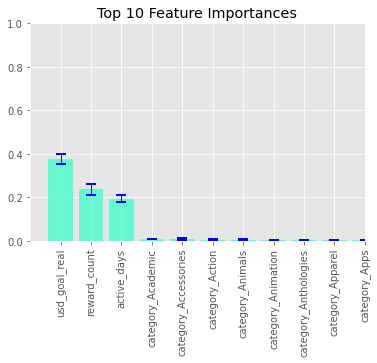

In [29]:
plt.bar(X_num_train.columns, importances[indicies], color="#33ffcc", yerr=std[indicies], align="center", alpha=0.7, error_kw=dict(ecolor='blue', lw=1, capsize=5, capthick=2))
plt.ylim([0, 1]);
plt.xlim([-1, 10])
plt.xticks(rotation =90)
plt.title('Top 10 Feature Importances')

# What features surprised you

### Other Models

In [30]:
# cross validate on training data, 5 folds default, then take mean of fold accuracies

log = cross_val_score(LogisticRegression(max_iter =400, random_state = 42), X_num_train, y_train, scoring = 'accuracy').mean()
log

0.693794642291406

In [31]:
log_cross = cross_validate(LogisticRegression(max_iter =400, random_state = 42), X_num_train, y_train, scoring = ['accuracy', 'precision', 'recall'])


In [32]:
log_cross

{'fit_time': array([3.08886123, 4.14327788, 3.07969904, 2.91857314, 4.99767995]),
 'score_time': array([0.0940671 , 0.09287214, 0.09253097, 0.09176683, 0.09218812]),
 'test_accuracy': array([0.6878836 , 0.69911286, 0.68881285, 0.69117621, 0.70198769]),
 'test_precision': array([0.62368973, 0.65377817, 0.62531398, 0.62857143, 0.65890281]),
 'test_recall': array([0.4202571 , 0.41801658, 0.42201921, 0.42889433, 0.42362027])}

In [33]:
log_cross.update((x, y.mean()) for x, y in log_cross.items())
log_cross

{'fit_time': 3.6456182479858397,
 'score_time': 0.09268503189086914,
 'test_accuracy': 0.693794642291406,
 'test_precision': 0.6380512229090229,
 'test_recall': 0.4225614969193967}

In [76]:
# Random Forest Classifier
rfc_cross = cross_validate(RandomForestClassifier(**hyperparameters, random_state=42), X_num_train, y_train, scoring = ['accuracy', 'precision', 'recall'])
rfc_cross.update((x, y.mean()) for x, y in rfc_cross.items())
rfc_cross


{'fit_time': 48.88636674880981,
 'score_time': 1.420424222946167,
 'test_accuracy': 0.6999322802833976,
 'test_precision': 0.6067780969794584,
 'test_recall': 0.5650540656727248}

In [34]:
# gradient boosted Classifier

gradient_cross = cross_validate(GradientBoostingClassifier(random_state = 42), X_num_train, y_train, scoring = ['accuracy', 'precision', 'recall'])
gradient_cross.update((x, y.mean()) for x, y in gradient_cross.items())
gradient_cross


{'fit_time': 65.94710536003113,
 'score_time': 0.30576581954956056,
 'test_accuracy': 0.7298092435461584,
 'test_precision': 0.656496290730536,
 'test_recall': 0.5844078018304893}

In [35]:
# Adaboost
ada_cross = cross_validate(AdaBoostClassifier(random_state = 42), X_num_train, y_train, scoring = ['accuracy', 'precision', 'recall'])
ada_cross.update((x, y.mean()) for x, y in ada_cross.items())
ada_cross

{'fit_time': 23.88212833404541,
 'score_time': 1.3148228168487548,
 'test_accuracy': 0.7218655664665412,
 'test_precision': 0.6520649456824634,
 'test_recall': 0.5519725011788095}

In [36]:
# Neural Net Base Model (compare adam (0.649 accuracy), *adagrad (0.690 accuracy), and adadelta(0.632) optimizer)

# create tf model
tf_feature_model = keras.models.Sequential()

# add layers (1 unit(neuron), 1 layer)
tf_feature_model.add(keras.layers.Dense(units = 1, input_dim = 210))
tf_feature_model.add(keras.layers.Activation('sigmoid'))

#compile
tf_feature_model.compile(loss='binary_crossentropy', optimizer='adagrad', metrics =['accuracy'])

#fit
tf_feature_model.fit(X_num_train, y_train, epochs=10, batch_size=32, verbose =1, validation_split = 0.2)

Epoch 1/10
7088/7088 [==============================] - 5s 742us/step - loss: 3265.7244 - accuracy: 0.3734 - val_loss: 2276.1963 - val_accuracy: 0.3743
Epoch 2/10
7088/7088 [==============================] - 5s 726us/step - loss: 2431.4897 - accuracy: 0.3730 - val_loss: 1756.3604 - val_accuracy: 0.3732
Epoch 3/10
7088/7088 [==============================] - 5s 724us/step - loss: 1887.6716 - accuracy: 0.3723 - val_loss: 1361.5560 - val_accuracy: 0.3725
Epoch 4/10
7088/7088 [==============================] - 5s 732us/step - loss: 1447.5916 - accuracy: 0.3701 - val_loss: 1026.9784 - val_accuracy: 0.3692
Epoch 5/10
7088/7088 [==============================] - 5s 731us/step - loss: 1067.4415 - accuracy: 0.3692 - val_loss: 732.5110 - val_accuracy: 0.3678
Epoch 6/10
7088/7088 [==============================] - 5s 730us/step - loss: 729.1619 - accuracy: 0.3683 - val_loss: 468.0278 - val_accuracy: 0.3696
Epoch 7/10
7088/7088 [==============================] - 5s 735us/step - loss: 422.5363 - ac

In [37]:
# Neural Net Layered Model

# create tf model
tf_feature_model2 = keras.models.Sequential()

# add layers (24 units, 5 layers(1 dropout))
tf_feature_model2.add(keras.layers.Dense(units = 3, input_dim = 210))
tf_feature_model2.add(keras.layers.Activation(tf.nn.relu))

tf_feature_model2.add(keras.layers.Dense(units=10, activation=tf.nn.sigmoid))

tf_feature_model2.add(keras.layers.Dense(units =10, activation = tf.nn.tanh))

# tf_feature_model2.add(keras.layers.Dropout(rate=0.1))

tf_feature_model2.add(keras.layers.Dense(1))
tf_feature_model2.add(keras.layers.Activation('sigmoid'))

#compile
tf_feature_model2.compile(loss='binary_crossentropy', optimizer='adam', metrics =['accuracy'])

#fit
tf_feature_model2.fit(X_num_train, y_train, epochs=15, batch_size=32, verbose =1, validation_split = 0.2)

Epoch 1/15
7088/7088 [==============================] - 7s 992us/step - loss: 0.6544 - accuracy: 0.6280 - val_loss: 0.6366 - val_accuracy: 0.6307
Epoch 2/15
7088/7088 [==============================] - 7s 979us/step - loss: 0.6193 - accuracy: 0.6605 - val_loss: 0.7007 - val_accuracy: 0.6363
Epoch 3/15
7088/7088 [==============================] - 7s 986us/step - loss: 0.6111 - accuracy: 0.6754 - val_loss: 0.5864 - val_accuracy: 0.7084
Epoch 4/15
7088/7088 [==============================] - 7s 978us/step - loss: 0.6206 - accuracy: 0.6576 - val_loss: 0.5735 - val_accuracy: 0.7016
Epoch 5/15
7088/7088 [==============================] - 7s 988us/step - loss: 0.5688 - accuracy: 0.7039 - val_loss: 0.5601 - val_accuracy: 0.7146
Epoch 6/15
7088/7088 [==============================] - 7s 981us/step - loss: 0.5631 - accuracy: 0.7080 - val_loss: 0.5748 - val_accuracy: 0.7040
Epoch 7/15
7088/7088 [==============================] - 7s 1ms/step - loss: 0.5573 - accuracy: 0.7097 - val_loss: 0.5473 - v

In [38]:
# adam 0.709 Accuracy
# adagrad  0.708 Accuracy
# adadelta 0.625 Accuracy

In [39]:
#train accuracy, precision, recall
y_pred = tf_feature_model2.predict(X_num_train)
y_pred = 1 * (y_pred > 0.5)
accuracy_score(y_train, y_pred), precision_score(y_train, y_pred), recall_score(y_train, y_pred)

(0.7147261337020628, 0.5994779833174789, 0.7181416637628201)

# NLP

In [40]:
# preprocessor from helpers.py

vectorizer = TfidfVectorizer(preprocessor=preprocesser, stop_words=stopwords_list())
vectorized_train = vectorizer.fit_transform(X_train.blurb)

In [41]:
# Vectorize Holdout set

vectorized_test = vectorizer.transform(X_test.blurb)

In [42]:
vectorized_train.shape

(283496, 130295)

In [88]:
# vocabulary
sorted(vectorizer.vocabulary_.items(), key=lambda x: x[1], reverse=True)

[('ｗｅｂ', 130294),
 ('ｔｈｅ', 130293),
 ('ｆｏｒ', 130292),
 ('ａｌｌ', 130291),
 ('ﬁtting', 130290),
 ('ﬁlm', 130289),
 ('한글자막도', 130288),
 ('하크네시야', 130287),
 ('프로젝트', 130286),
 ('정상에', 130285),
 ('작음을', 130284),
 ('있습니다', 130283),
 ('올라', 130282),
 ('역yeok', 130281),
 ('앨범', 130280),
 ('보리라', 130279),
 ('반드시', 130278),
 ('뭇산이', 130277),
 ('내려다', 130276),
 ('김혜은', 130275),
 ('교회', 130274),
 ('黑人在中国', 130273),
 ('魔導師', 130272),
 ('青花瓷', 130271),
 ('赤毛のアン', 130270),
 ('誰かが一度あなたのために立ち上がっているので', 130269),
 ('藝術家冰淇淋使用當地當季食材', 130268),
 ('自道', 130267),
 ('简介', 130266),
 ('笑顔になれるダンス映画をつくりたい', 130265),
 ('直到今天', 130264),
 ('盡管中文信息科技如此重要而龐大', 130263),
 ('电影', 130262),
 ('浮世絵ヒーロー', 130261),
 ('毛を刈ったアルパカのために', 130260),
 ('會當凌絶頂', 130259),
 ('日本のアン', 130258),
 ('日本における', 130257),
 ('新しいヒプホプアルブム', 130256),
 ('我々はウォルマートで変更を加える必要があります', 130255),
 ('我々はすべてのアメリカの労働者のためのよりよい仕事をする場合', 130254),
 ('彡ame', 130253),
 ('増山士郎', 130252),
 ('在中国巡回演出', 130251),
 ('在世上卻從來沒有過任何一家博物館有專門展出過這人類科技史上關鍵的一章', 130250),
 ('善惡', 130

In [43]:
# Logistic Regression 5 folds

log_cross_nlp = cross_validate(LogisticRegression(max_iter = 400, random_state = 42), vectorized_train, y_train, scoring = ['accuracy', 'precision', 'recall'], n_jobs = -1)
log_cross_nlp.update((x, y.mean()) for x, y in log_cross_nlp.items())
log_cross_nlp


{'fit_time': 14.589604759216309,
 'score_time': 0.04723620414733887,
 'test_accuracy': 0.6829126378652355,
 'test_precision': 0.6181822771094714,
 'test_recall': 0.4012865113949182}

In [44]:
# Random Forest Classifier using trial and error parameters, rather than waiting for grid search

rfc = RandomForestClassifier(criterion='gini', max_depth = 200, n_estimators = 50, max_features = 'auto', oob_score = True, random_state=42).fit(vectorized_train, y_train)
rfc.oob_score_

0.6621539633716172

In [45]:
# Trail and out-of-bag Error Results
'''
entropy, max_depth =100, n_estimators = 50 : 0.6447992211530321
gini, max_depth = 100, n_estimators = 50 : 6457022321302593
gini, max_depth = 100, n_estimators = 100 : 0.6471167141688066
gini, max_depth = 200, n_estimators = 50 : 0.662499647261337  ***
gini, max_depth = 500, n_estimators = 50 : 0.6653391934983209

'''

'\nentropy, max_depth =100, n_estimators = 50 : 0.6447992211530321\ngini, max_depth = 100, n_estimators = 50 : 6457022321302593\ngini, max_depth = 100, n_estimators = 100 : 0.6471167141688066\ngini, max_depth = 200, n_estimators = 50 : 0.662499647261337  ***\ngini, max_depth = 500, n_estimators = 50 : 0.6653391934983209\n\n'

In [78]:
# random forest classifier 2 folds

rfc_cross_nlp = cross_validate(RandomForestClassifier(criterion='gini', max_depth = 200, n_estimators = 50, max_features = 'auto', oob_score = True, random_state=42),
                                                    vectorized_train, y_train, scoring = ['accuracy', 'precision', 'recall'],cv=2, n_jobs=-1)
rfc_cross_nlp.update((x, y.mean()) for x, y in rfc_cross_nlp.items())
rfc_cross_nlp


{'fit_time': 312.77153158187866,
 'score_time': 4.247218489646912,
 'test_accuracy': 0.6619458475604594,
 'test_precision': 0.6788704718020582,
 'test_recall': 0.18486357128090192}

In [46]:
# gradient boosted Classifier 2 folds

gradient_cross_nlp = cross_validate(GradientBoostingClassifier(random_state = 42), vectorized_train, y_train, scoring = ['accuracy', 'precision', 'recall'],cv=2, n_jobs=-1)
gradient_cross_nlp.update((x, y.mean()) for x, y in gradient_cross_nlp.items())
gradient_cross_nlp


{'fit_time': 777.2933526039124,
 'score_time': 0.25270354747772217,
 'test_accuracy': 0.6472437000874791,
 'test_precision': 0.6686749825594971,
 'test_recall': 0.11528429089324269}

In [47]:
# Naive Bayes Classifier 5 Folds

nb_cross_nlp = cross_validate(MultinomialNB(alpha=0.1), vectorized_train, y_train, scoring = ['accuracy', 'precision', 'recall'],cv=5, n_jobs=-1)
nb_cross_nlp.update((x, y.mean()) for x, y in nb_cross_nlp.items())
nb_cross_nlp


{'fit_time': 0.1247633934020996,
 'score_time': 0.05799870491027832,
 'test_accuracy': 0.6707537389263699,
 'test_precision': 0.5986140544509543,
 'test_recall': 0.3670902109854882}

In [48]:
X_num_train.head()

,usd_goal_real,reward_count,active_days,category_Academic,category_Accessories,category_Action,category_Animals,category_Animation,category_Anthologies,category_Apparel,...,country_JP,country_LU,country_MX,"country_N,0""",country_NL,country_NO,country_NZ,country_SE,country_SG,country_US
149018,15034.20,6,31,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
349875,2900.00,10,29,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
135916,80000.00,9,32,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
230224,558.49,8,32,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
81075,8500.00,5,58,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [49]:
vectorized_train

<283496x130295 sparse matrix of type '<class 'numpy.float64'>'
	with 3231855 stored elements in Compressed Sparse Row format>

In [50]:
# import scipy.sparse
# vectorized_train_matrix = scipy.sparse.eye(283496, 130295)
# vectorized_train_matrix = pd.DataFrame.sparse.from_spmatrix(vectorized_train_matrix)

In [51]:
# # neural net (stops kernel)

# # create tf model
# tf_nlp_model = keras.models.Sequential()

# # add layers (65 unit(neuron), 2 layers)
# tf_nlp_model.add(keras.layers.Dense(units = 64, activation='relu', input_dim = 130295))
# tf_nlp_model.add(keras.layers.Dense(1, activation='sigmoid'))

# #compile
# tf_nlp_model.compile(loss='binary_crossentropy', optimizer='adam', metrics =['accuracy'])

# #fit
# tf_nlp_model.fit(vectorized_train_matrix, y_train, epochs=10, batch_size=32, verbose =1, validation_split = 0.2)

In [52]:
# Probabilities = MultinomialNB().fit(vectorized_train, y_train).predict_proba([sample_transform]).round(2)[0].tolist()

In [53]:
# fig, ax = plt.subplots(1, figsize=(18,6))
# df = calculate_threshold_values(log_model.predict_proba(X)[:,1], y)
# plot_roc(ax, df)

In [54]:
# roc_auc_score(y_hat, y2_test)

In [55]:
# confusion_matrix(y_hat, y2_test)

In [56]:
# instead of cross_val_score for logistic

# cross_val = LogisticRegressionCV(cv=5, max_iter=300, n_jobs=-1).fit(train2,y2_train)
# cross_val.score(test2, y2_test)

# Combining Models

In [57]:
# get probability predictions from best models and run them through a decision tree classifier
# use flow chart to show this

In [58]:
# FINAL NLP Model
nlp_log_model = LogisticRegressionCV(cv=5, max_iter=400, n_jobs=-1).fit(vectorized_train,y_train)
nlp_log_model_probs = nlp_log_model.predict_proba(vectorized_train)

In [59]:
# FINAL Feature Log Model

feature_log_model = LogisticRegressionCV(cv=5, max_iter=400, n_jobs=-1).fit(X_num_train,y_train)
feature_log_model_probs = feature_log_model.predict_proba(X_num_train)

In [90]:
# Feature Gradient Boosted Classifier Model
feature_gradient_model = GradientBoostingClassifier().fit(X_num_train, y_train)
feature_gradient_model_probs = feature_gradient_model.predict_proba(X_num_train)


In [60]:
feature_log_model.classes_

array([0, 1])

In [91]:
feature_gradient_model.classes_

array([0, 1])

In [61]:
nlp_log_model.classes_

array([0, 1])

In [62]:
feature_log_model_probs

array([[0.66949284, 0.33050716],
       [0.46143044, 0.53856956],
       [0.88819039, 0.11180961],
       ...,
       [0.90330769, 0.09669231],
       [0.67269089, 0.32730911],
       [0.46367756, 0.53632244]])

In [63]:
nlp_log_model_probs

array([[0.52380526, 0.47619474],
       [0.69755151, 0.30244849],
       [0.70868282, 0.29131718],
       ...,
       [0.94323107, 0.05676893],
       [0.76183185, 0.23816815],
       [0.49559854, 0.50440146]])

In [64]:
feature_log_model_probs[:,1]

array([0.33050716, 0.53856956, 0.11180961, ..., 0.09669231, 0.32730911,
       0.53632244])

In [96]:
log_log_probs_class_1 = pd.DataFrame({'features':feature_log_model_probs[:,1], 'nlp':nlp_log_model_probs[:,1]})
log_log_probs_class_1.head()

,features,nlp
0,0.330507,0.476195
1,0.538570,0.302448
2,0.111810,0.291317
3,0.483975,0.548423
4,0.174284,0.275207


In [97]:
gradient_log_probs_class_1 = pd.DataFrame({'features':feature_gradient_model_probs[:,1], 'nlp':nlp_log_model_probs[:,1]})
gradient_log_probs_class_1.head()

,features,nlp
0,0.246765,0.476195
1,0.541532,0.302448
2,0.193713,0.291317
3,0.751537,0.548423
4,0.121730,0.275207


In [68]:
log_log_probs_class_1.shape

(283496, 2)

In [69]:
y_train.shape

(283496,)

In [70]:
# Merging Models with DecisionTreeClassifier

tree = cross_val_score(DecisionTreeClassifier(),log_log_probs_class_1, y_train, scoring = 'accuracy').mean()
tree

0.6647218997638229

In [72]:
forest_1 = cross_val_score(RandomForestClassifier(),log_log_probs_class_1, y_train, scoring = 'accuracy').mean()

In [73]:
forest_1

0.7160242150036209

In [98]:
forest_2 = cross_val_score(RandomForestClassifier(),gradient_log_probs_class_1, y_train, scoring = 'accuracy').mean()

In [100]:
forest_2

0.7308780385595732

In [71]:
log_1 = cross_val_score(LogisticRegression(),log_log_probs_class_1, y_train, scoring = 'accuracy').mean()
log_1

0.7480811089022874

In [101]:
log_2 = cross_val_score(LogisticRegression(),gradient_log_probs_class_1, y_train, scoring = 'accuracy').mean()

In [102]:
# Final Merged Model Accuracy Score

log_2

0.7618802456102467

In [103]:
# FINAL MERGED Model
Final_model = LogisticRegression().fit(gradient_log_probs_class_1, y_train)

# Final Holdout Set Test

In [107]:
# Predict NLP Test

nlp_log_model_probs_test = nlp_log_model.predict_proba(vectorized_test)

In [108]:
# Predict Feature Test

feature_gradient_model_probs_test = feature_gradient_model.predict_proba(X_num_test)

In [109]:
# Merge NLP (Logistic) and Feature (Gradient Boosting) Probabilities

X_final = pd.DataFrame({'features':feature_gradient_model_probs_test[:,1], 'nlp':nlp_log_model_probs_test[:,1]})



In [110]:
y_hat_test = Final_model.predict(X_final)

In [111]:
accuracy_score(y_test, y_hat_test)

0.7445220458553792

In [113]:
recall_score(y_test, y_hat_test)

0.6007157656809192

In [114]:
precision_score(y_test, y_hat_test)

0.6798840283107359

In [115]:
confusion_matrix(y_hat_test, y_test)

array([[36822, 10599],
       [ 7508, 15946]])

In [120]:
# cross_val = LogisticRegressionCV(cv=5, max_iter=400, n_jobs=-1).fit(gradient_log_probs_class_1, y_train)

# fig, ax = plt.subplots(1, figsize=(18,6))
# df_ = calculate_threshold_values(cross_val.predict_proba(X_final)[:,1], y_test)
# plot_roc(ax, df_)

In [119]:
roc_auc_score(y_hat_test, y_test)

0.7281877280795788

In [74]:
# Key Takaways

# Picking a reasonable pledge goal is very important for success

In [75]:
# Future Direction

# Use features from shortly (~1 week) after the project has launched rather than pre-launch, 
# such as staff pick, comment count, backers and pledged instead